In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

from sklearn.impute import MissingIndicator, KNNImputer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from preprocessing import expand_cabin, expand_passenger_id_to_group, expand_name

sns.set_theme()

tfd = tfp.distributions
tfb = tfp.bijectors

DATASET_PATH = "/Users/dincaus/datasets/spaceship-titanic"

TRAIN_PATH = os.path.join(DATASET_PATH, "train.csv")
TEST_PATH = os.path.join(DATASET_PATH, "test.csv")

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [12]:
all_data = pd.concat([train_df, test_df])
all_data[["Deck", "CabinNumber", "Side"]] = expand_cabin(all_data)
all_data["PassengerGroup"] = expand_passenger_id_to_group(all_data)
all_data[["FirstName", "LastName"]] = expand_name(all_data)

all_data = all_data.drop(columns=["Cabin", ]).reset_index(drop=True)
all_data["Test"] = all_data["Transported"].apply(lambda x: True if x is np.nan else False)

last_name_mapping = pd.concat([all_data.groupby(by="LastName")["LastName"].count().rename("Count"), pd.Series([all_data.groupby(by="LastName")["LastName"].count().rename("Count").mode()[0]], index=[np.nan])])

all_data["FamilySize"] = all_data["LastName"].apply(lambda x: last_name_mapping[x])
all_data["HasMissing"] = all_data.isna().any(axis=1)

all_data = all_data.drop(columns=["FirstName", "LastName", "Name"])

In [13]:
BOOL_FEATURES = ["CryoSleep", "VIP", "PassengerGroup"]
CATEGORICAL_FEATURES = ["HomePlanet", "Destination", "Deck", "Side"]
NUMERICAL_FEATURES = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNumber", "FamilySize"]

In [14]:
BOOL_MAPPER = {
    True: 1,
    False: 0
}

all_data["VIP"] = all_data["VIP"].apply(lambda x: BOOL_MAPPER.get(x, np.nan))
all_data["CryoSleep"] = all_data["CryoSleep"].apply(lambda x: BOOL_MAPPER.get(x, np.nan))

In [15]:
all_data["TotalMoneySpent"] = all_data["Spa"] + all_data["VRDeck"] + all_data["FoodCourt"] + all_data["RoomService"] + all_data["ShoppingMall"]

all_data["Q_TotalMoneySpent"] =  QuantileTransformer(n_quantiles=2_000).fit_transform(all_data["TotalMoneySpent"].to_numpy().reshape(-1, 1))
all_data["L_TotalMoneySpent"] = np.log1p(all_data["TotalMoneySpent"].to_numpy())

In [16]:
all_data[NUMERICAL_FEATURES] = KNNImputer(n_neighbors=13, weights="distance").fit_transform(all_data[NUMERICAL_FEATURES])

In [17]:
for num_feat in NUMERICAL_FEATURES:
    all_data[f"Q_{num_feat}"] = QuantileTransformer(n_quantiles=2_000).fit_transform(all_data[num_feat].to_numpy().reshape(-1, 1))
    all_data[f"L_{num_feat}"] = np.log1p(all_data[num_feat].to_numpy())

NUMERICAL_FEATURES += ["TotalMoneySpent", ]

In [18]:
train_data = all_data[~all_data["Transported"].isna()]

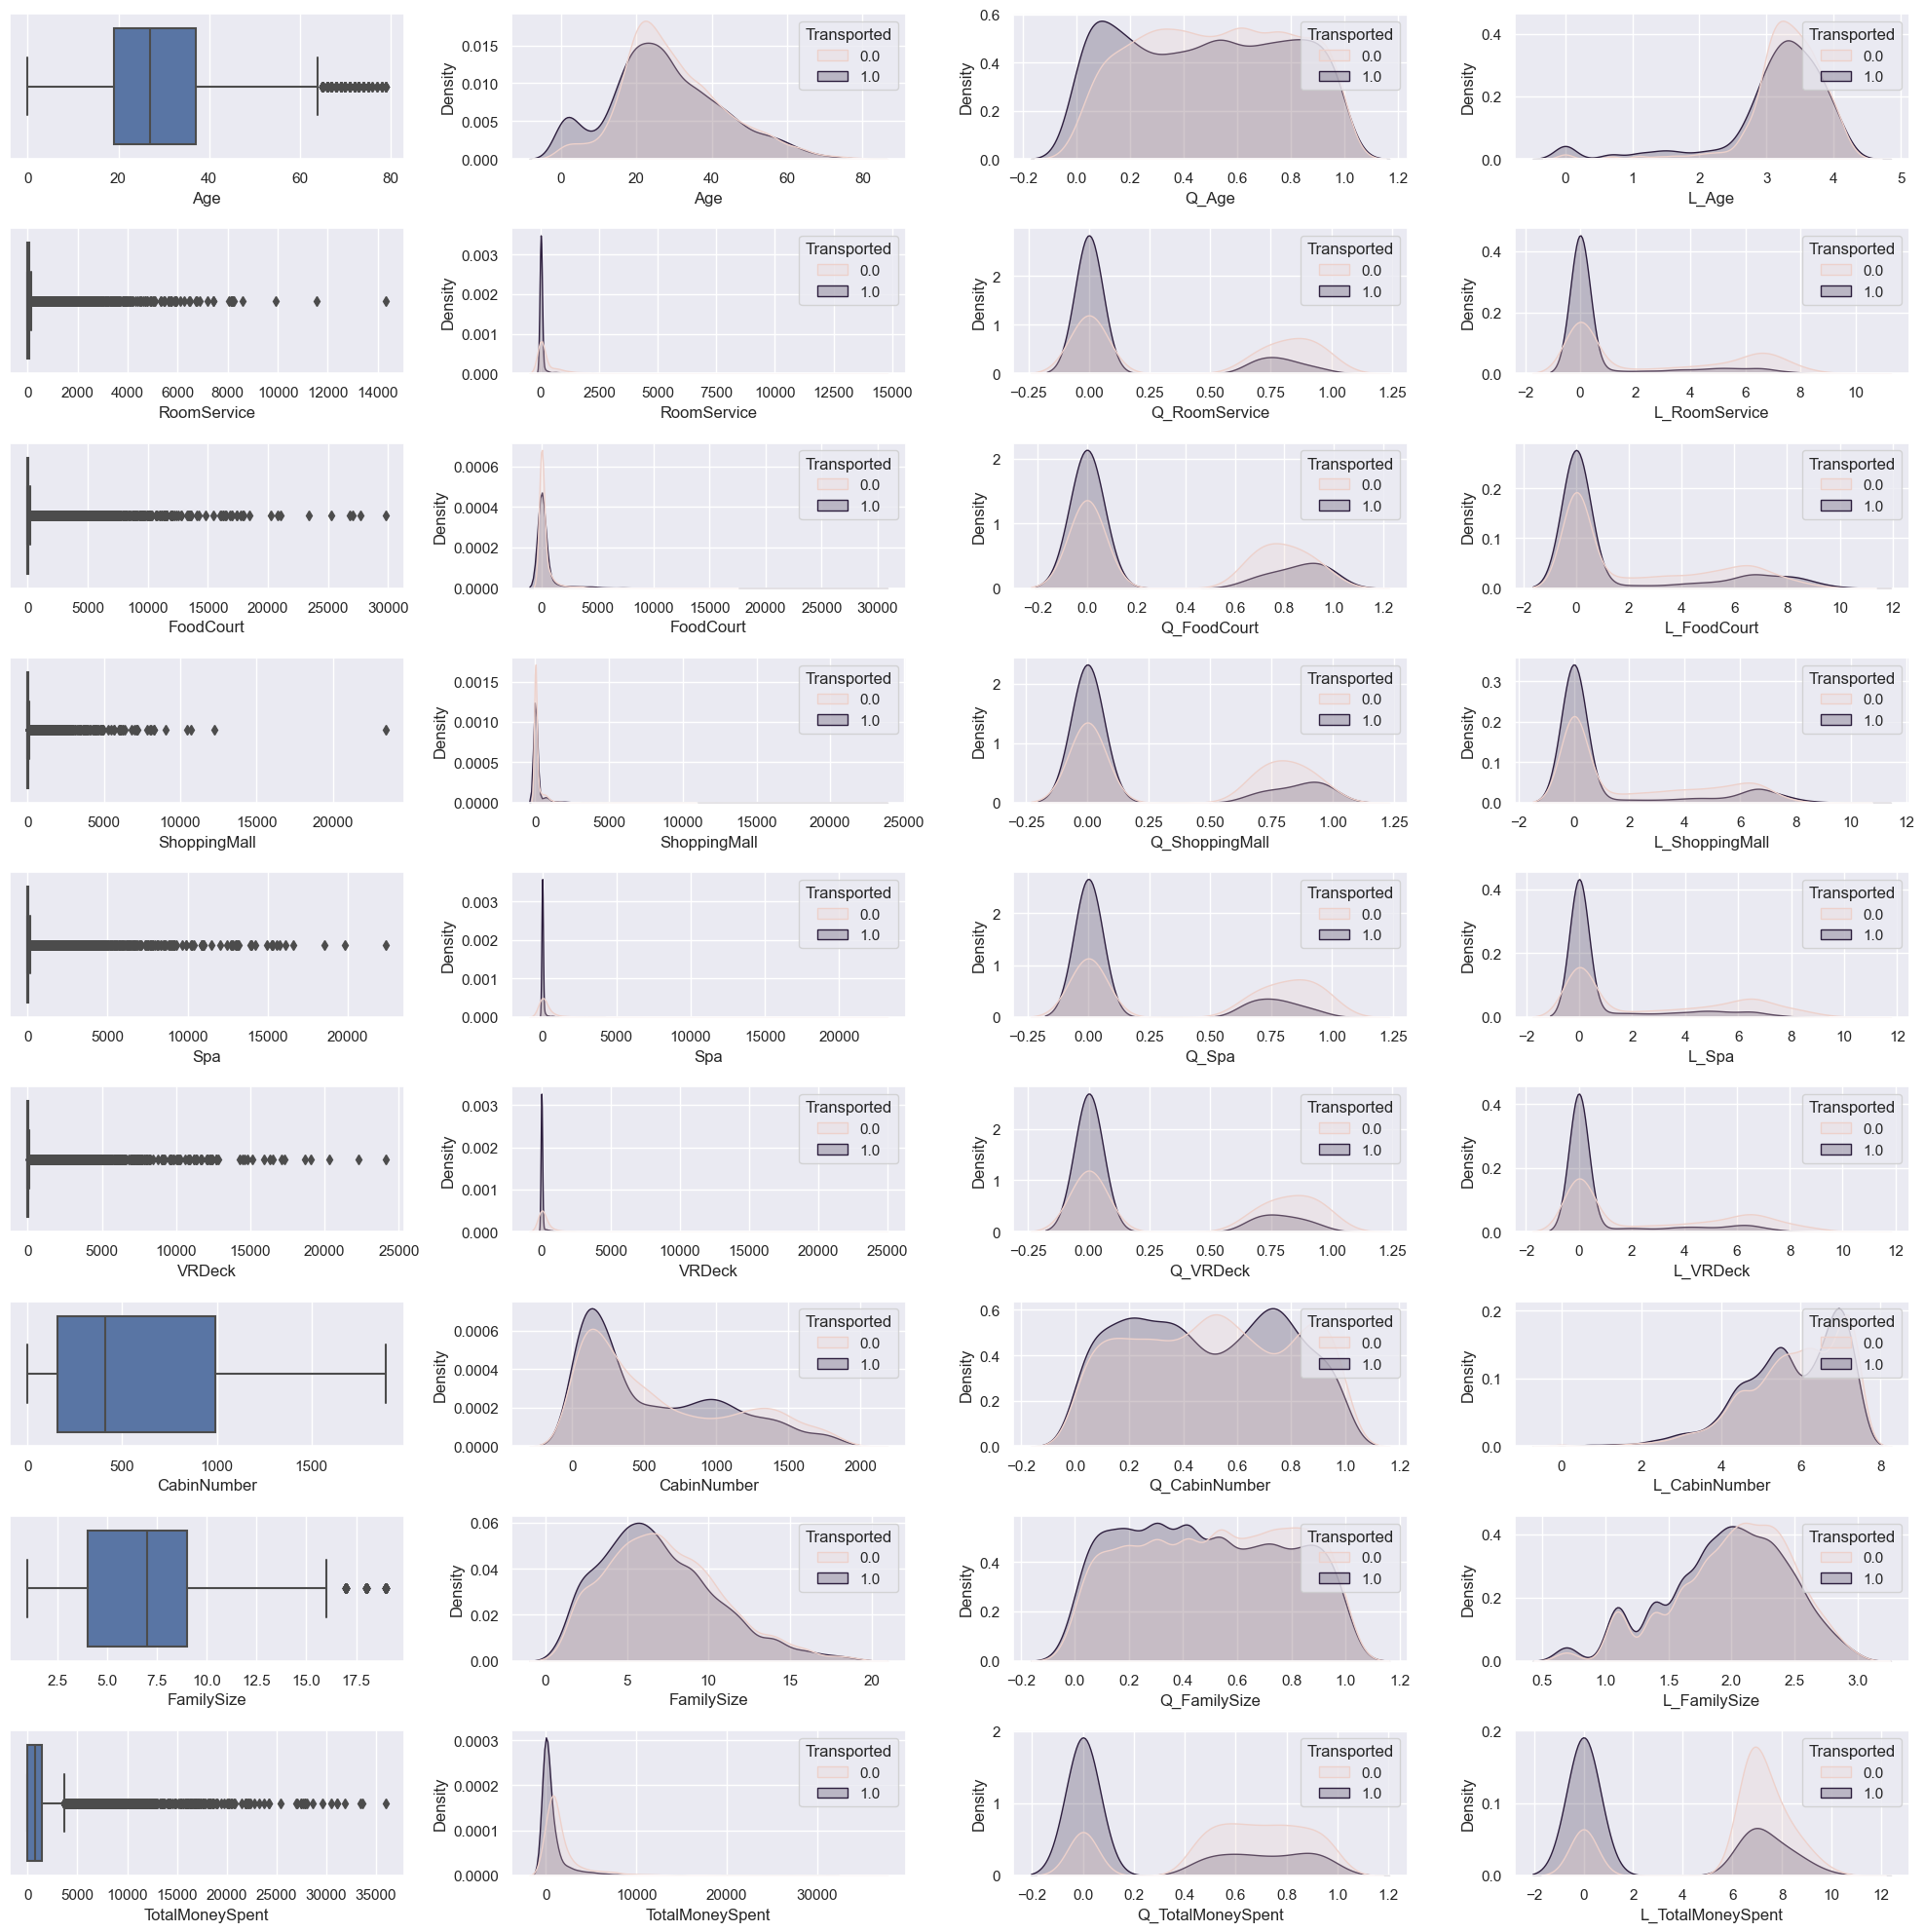

In [19]:
_, axs = plt.subplots(9, 4, figsize=(20, 20))

sns.boxplot(data=all_data, x="Age", ax=axs[0][0])
sns.kdeplot(data=all_data, x="Age", hue="Transported", fill=True, ax=axs[0][1])
sns.kdeplot(data=all_data, x="Q_Age", hue="Transported", fill=True, ax=axs[0][2])
sns.kdeplot(data=all_data, x="L_Age", hue="Transported", fill=True, ax=axs[0][3])

sns.boxplot(data=all_data, x="RoomService", ax=axs[1][0])
sns.kdeplot(data=all_data, x="RoomService", hue="Transported", fill=True, ax=axs[1][1])
sns.kdeplot(data=all_data, x="Q_RoomService", hue="Transported", fill=True, ax=axs[1][2])
sns.kdeplot(data=all_data, x="L_RoomService", hue="Transported", fill=True, ax=axs[1][3])

sns.boxplot(data=all_data, x="FoodCourt", ax=axs[2][0])
sns.kdeplot(data=all_data, x="FoodCourt", hue="Transported", fill=True, ax=axs[2][1])
sns.kdeplot(data=all_data, x="Q_FoodCourt", hue="Transported", fill=True, ax=axs[2][2])
sns.kdeplot(data=all_data, x="L_FoodCourt", hue="Transported", fill=True, ax=axs[2][3])

sns.boxplot(data=all_data, x="ShoppingMall", ax=axs[3][0])
sns.kdeplot(data=all_data, x="ShoppingMall", hue="Transported", fill=True, ax=axs[3][1])
sns.kdeplot(data=all_data, x="Q_ShoppingMall", hue="Transported", fill=True, ax=axs[3][2])
sns.kdeplot(data=all_data, x="L_ShoppingMall", hue="Transported", fill=True, ax=axs[3][3])

sns.boxplot(data=all_data, x="Spa", ax=axs[4][0])
sns.kdeplot(data=all_data, x="Spa", hue="Transported", fill=True, ax=axs[4][1])
sns.kdeplot(data=all_data, x="Q_Spa", hue="Transported", fill=True, ax=axs[4][2])
sns.kdeplot(data=all_data, x="L_Spa", hue="Transported", fill=True, ax=axs[4][3])

sns.boxplot(data=all_data, x="VRDeck", ax=axs[5][0])
sns.kdeplot(data=all_data, x="VRDeck", hue="Transported", fill=True, ax=axs[5][1])
sns.kdeplot(data=all_data, x="Q_VRDeck", hue="Transported", fill=True, ax=axs[5][2])
sns.kdeplot(data=all_data, x="L_VRDeck", hue="Transported", fill=True, ax=axs[5][3])

sns.boxplot(data=all_data, x="CabinNumber", ax=axs[6][0])
sns.kdeplot(data=all_data, x="CabinNumber", hue="Transported", fill=True, ax=axs[6][1])
sns.kdeplot(data=all_data, x="Q_CabinNumber", hue="Transported", fill=True, ax=axs[6][2])
sns.kdeplot(data=all_data, x="L_CabinNumber", hue="Transported", fill=True, ax=axs[6][3])

sns.boxplot(data=all_data, x="FamilySize", ax=axs[7][0])
sns.kdeplot(data=all_data, x="FamilySize", hue="Transported", fill=True, ax=axs[7][1])
sns.kdeplot(data=all_data, x="Q_FamilySize", hue="Transported", fill=True, ax=axs[7][2])
sns.kdeplot(data=all_data, x="L_FamilySize", hue="Transported", fill=True, ax=axs[7][3])

sns.boxplot(data=all_data, x="TotalMoneySpent", ax=axs[8][0])
sns.kdeplot(data=all_data, x="TotalMoneySpent", hue="Transported", fill=True, ax=axs[8][1])
sns.kdeplot(data=all_data, x="Q_TotalMoneySpent", hue="Transported", fill=True, ax=axs[8][2])
sns.kdeplot(data=all_data, x="L_TotalMoneySpent", hue="Transported", fill=True, ax=axs[8][3])

plt.tight_layout()
plt.show()

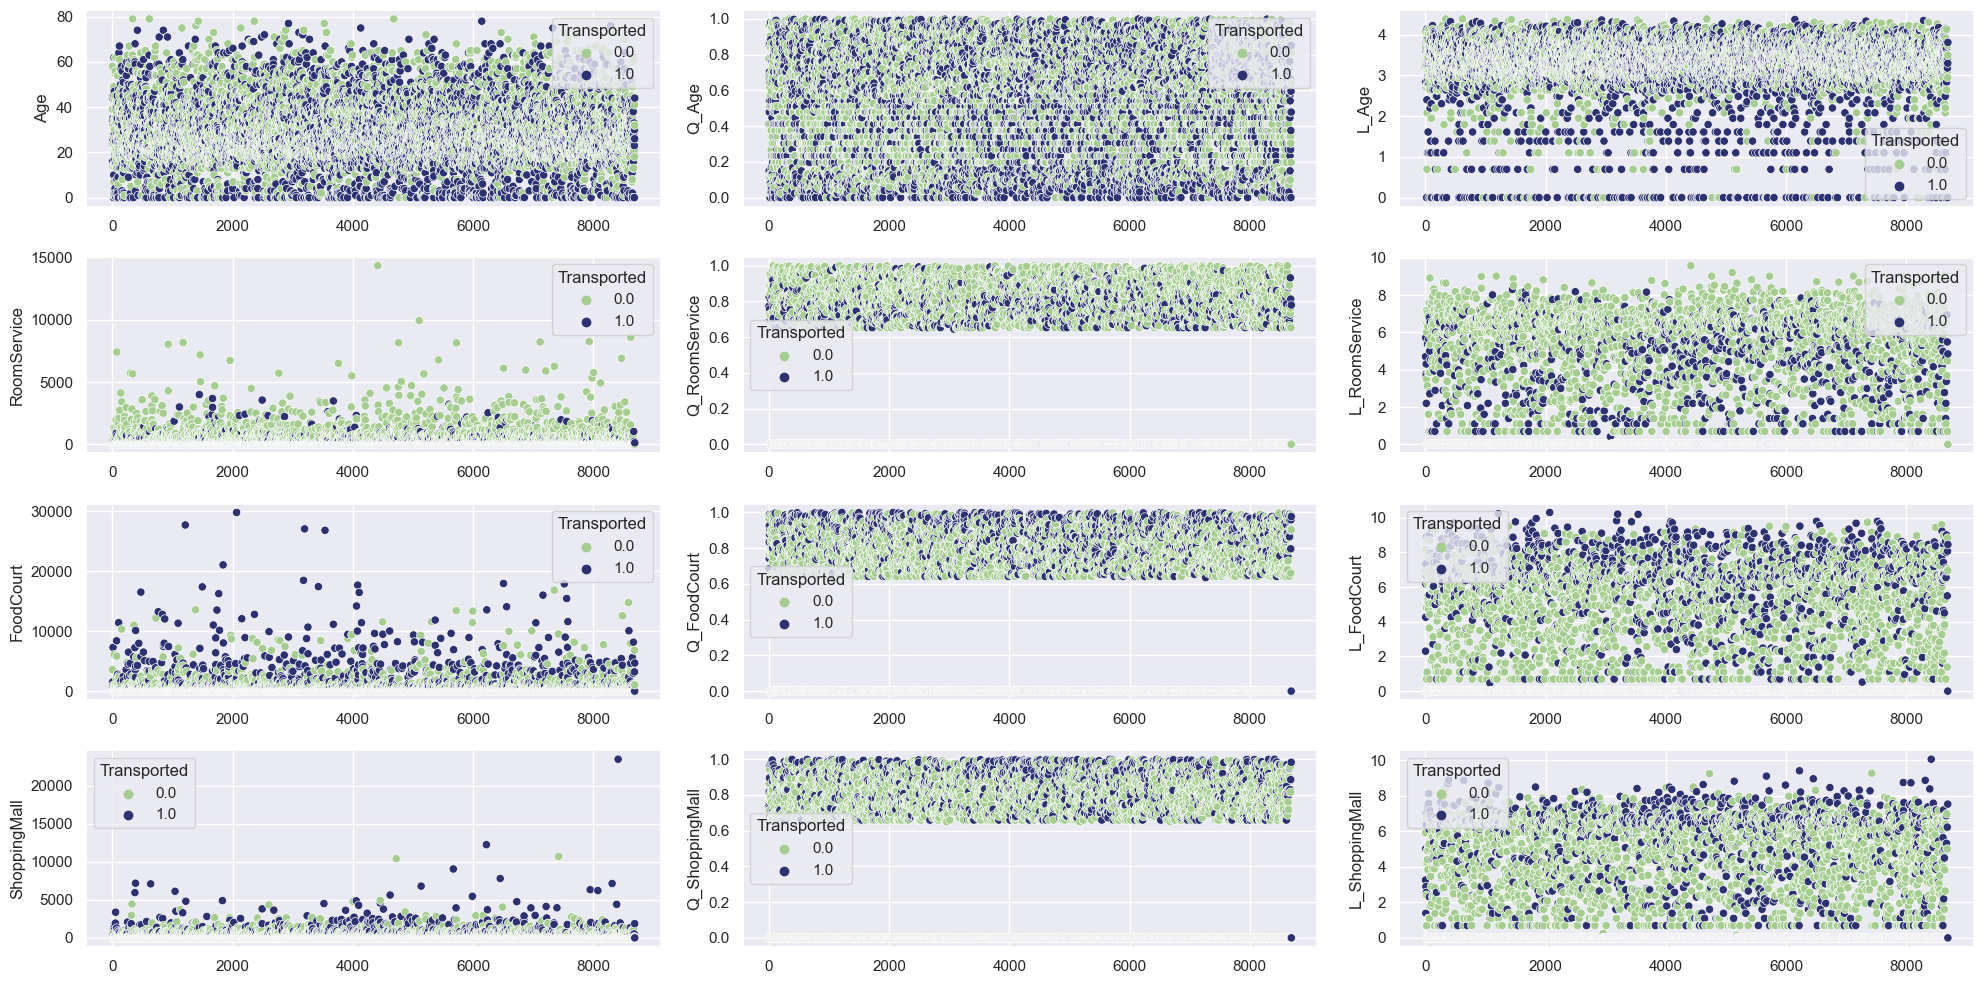

In [43]:
_, axs = plt.subplots(4, 3, figsize=(20, 10))

sns.scatterplot(data=all_data, x=all_data.index, y="Age", hue="Transported", palette="crest", ax=axs[0][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Q_Age", hue="Transported", palette="crest", ax=axs[0][1])
sns.scatterplot(data=all_data, x=all_data.index, y="L_Age", hue="Transported", palette="crest", ax=axs[0][2])

sns.scatterplot(data=all_data, x=all_data.index, y="RoomService", hue="Transported", palette="crest", ax=axs[1][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Q_RoomService", hue="Transported", palette="crest", ax=axs[1][1])
sns.scatterplot(data=all_data, x=all_data.index, y="L_RoomService", hue="Transported", palette="crest", ax=axs[1][2])

sns.scatterplot(data=all_data, x=all_data.index, y="FoodCourt", hue="Transported", palette="crest", ax=axs[2][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Q_FoodCourt", hue="Transported", palette="crest", ax=axs[2][1])
sns.scatterplot(data=all_data, x=all_data.index, y="L_FoodCourt", hue="Transported", palette="crest", ax=axs[2][2])

sns.scatterplot(data=all_data, x=all_data.index, y="ShoppingMall", hue="Transported", palette="crest", ax=axs[3][0])
sns.scatterplot(data=all_data, x=all_data.index, y="Q_ShoppingMall", hue="Transported", palette="crest", ax=axs[3][1])
sns.scatterplot(data=all_data, x=all_data.index, y="L_ShoppingMall", hue="Transported", palette="crest", ax=axs[3][2])


plt.tight_layout()
plt.show()